###  Τable of contents:

Data Source: [here](https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1?select=Loan_status_2007-2020Q3.gzip)

1) [Cleaning Process](#section0)
2) [Correlation Analysis](#section1)
3) [Principal Components Analysis](#section2)
4) [Distribution analysis for selected features](#section3)
5) [Regression Analysis](#section4)

In [ ]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pandas as pd
import numpy as np
import os
from fitter import Fitter, get_common_distributions
from scipy.stats import skew, kurtosis, zscore, pearsonr, kstest, probplot, jarque_bera
from tqdm.auto import tqdm
from pydantic.utils import deep_update
from sklearn.preprocessing import StandardScaler
import itertools
import heapq
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('accepted.csv')

---
### Cleaning Process
<a id='section0'></a>

In [90]:
df.shape

(2260701, 151)

In [3]:
df1 = df.dropna(axis=1, how='all') #Drop empty features
array = ['Charged Off', 'Fully Paid']
df1 = df1.loc[df1['loan_status'].isin(array)] #Filter rows by loan_status

cleaner = {"loan_status": { "Fully Paid": 1.0, "Charged Off": 0.0}}
df1 = df1.replace(cleaner)
df1 = df1.select_dtypes(np.number) #Filter features by type, keep numbers only
df1.shape

(1345310, 113)

In [4]:
#Filter features based on percentage of NaN, zeros and number of unique values
deleted=[]
for column in df1.columns:
    boool = False

    zeros = (df1[column] == 0).sum()
    portion2 = (zeros / df1.shape[0]) * 100
    if portion2>50:
        boool = True
 
    missing = df1[column].isna().sum()
    portion = (missing / df1.shape[0]) * 100
    if portion>25 :
        boool = True

    if df1[column].nunique()==1:
        boool = True

    if boool:
        deleted.append(column)

df1.drop(deleted, axis = 1, inplace = True)
df1 = df1.dropna(axis=0, how='any') #Drop rows that include NaN
df1.reset_index(inplace=True, drop=True)

#Find and drop outliers
no_outliers_positions = df1[(np.abs(zscore(df1)) < 3).all(axis=1)].index  
outliers = list(set(df1.index)-set(no_outliers_positions))
df1.drop(outliers, axis=0, inplace=True)
df1.reset_index(inplace=True, drop=True)
df1.shape

(791751, 50)

---
### Correlation Analysis
<a id='section1'></a>

In [5]:
#Drop features based on correlations
cor_matrix = df1.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.45)]

df1.drop(to_drop, axis=1,inplace=True)
df1.reset_index(drop=True,inplace=True)
df1.shape

(791751, 16)

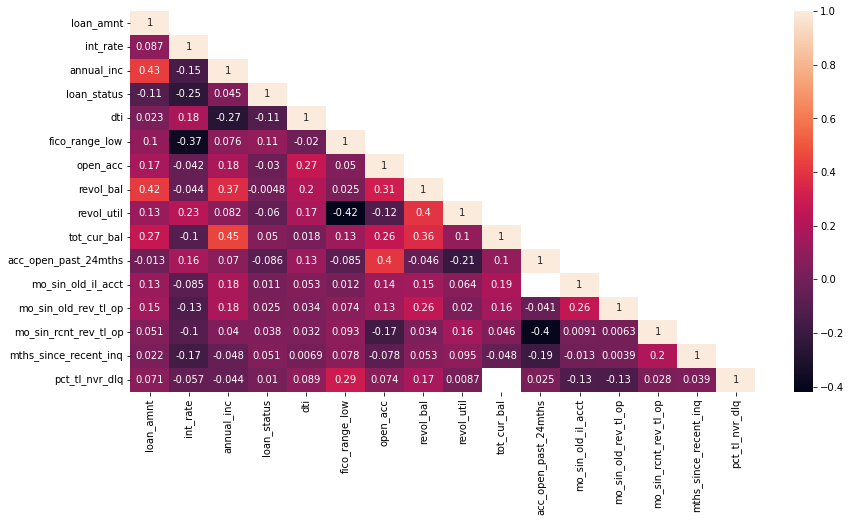

In [5]:
plt.figure(figsize=(14,7))

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(df1)
mask = np.invert(np.tril(p_values<0.05)) 

sns.heatmap(df1.corr(), annot=True, mask=mask)
plt.show()

---
### Principal Components Analysis
<a id='section2'></a>

In [6]:
#Standardization
scaler = StandardScaler()
scaler.fit(df1)
norm = scaler.transform(df1)
norm = pd.DataFrame(norm,columns=df1.columns)

#PCA
pca = PCA(0.8)
pca.fit(norm)
loadings = (pca.components_.T * np.sqrt(pca.explained_variance_)).round(2)

cols = ['PC%s' % i for i in range(1,  len(loadings.T) + 1)]
pca_df = pd.DataFrame(loadings,index=df1.columns,columns=cols)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
loan_amnt,0.63,-0.02,0.13,-0.04,0.33,0.30,0.08,-0.11,0.08,-0.46
int_rate,-0.14,-0.66,0.32,-0.00,0.20,0.15,-0.09,0.03,0.04,-0.36
annual_inc,0.69,0.15,-0.06,0.35,0.38,-0.03,0.09,0.07,-0.01,0.03
loan_status,0.01,0.39,-0.15,0.10,-0.14,-0.73,-0.19,-0.02,0.09,-0.45
dti,0.12,-0.40,0.13,-0.58,-0.48,0.01,-0.12,0.19,0.12,-0.10
fico_range_low,0.16,0.55,-0.48,-0.37,0.03,0.28,-0.14,0.01,0.01,-0.08
open_acc,0.50,-0.35,-0.42,-0.22,-0.21,-0.11,0.18,0.15,0.10,0.02
revol_bal,0.75,-0.06,0.26,-0.23,0.02,-0.16,-0.04,-0.22,0.07,0.11
revol_util,0.24,-0.20,0.79,-0.04,0.02,-0.29,-0.05,-0.09,-0.12,0.17
tot_cur_bal,0.67,0.04,-0.09,0.09,0.11,-0.14,-0.04,0.40,0.02,0.21


In [7]:
#Filter variables based on PCA loadings 
large=[
    pca_df[col].nlargest(3).index.values.tolist()
    for col in pca_df.columns
]

temp = list(itertools.chain.from_iterable(large))
large_counts = {x:temp.count(x) for x in temp}

temp = heapq.nlargest(10, large_counts.items(), key=lambda i: i[1])
keep = [x[0] for x in temp]
print(f'Selected features:\n{keep}')

Selected features:
['mo_sin_rcnt_rev_tl_op', 'annual_inc', 'tot_cur_bal', 'mo_sin_old_rev_tl_op', 'revol_bal', 'fico_range_low', 'revol_util', 'loan_amnt', 'dti', 'loan_status']


---
### Distribution analysis for selected features
<a id='section3'></a>

In [88]:
keep=['mo_sin_rcnt_rev_tl_op','annual_inc','tot_cur_bal','mo_sin_old_rev_tl_op','revol_bal','fico_range_low','revol_util','loan_amnt','dti','loan_status']
keep_df = df.loc[:,keep]

array = ['Charged Off', 'Fully Paid']
keep_df = keep_df.loc[keep_df['loan_status'].isin(array)]
cleaner = {"loan_status": { "Fully Paid": 1.0, "Charged Off": 0.0}}
keep_df = keep_df.replace(cleaner)
keep_df = keep_df.dropna(axis=0, how='any')

no_outliers_positions = keep_df[(np.abs(zscore(keep_df)) < 3).all(axis=1)].index
outliers = list(set(keep_df.index)-set(no_outliers_positions))
keep_df.drop(outliers, axis=0, inplace=True)
keep_df.reset_index(inplace=True, drop=True)
keep_df.shape

(1176856, 10)

In [89]:
kurt, skewness, k, j = dict(), dict(), dict(), dict()

for x in keep_df.columns:
    kurt[x] =round(kurtosis(keep_df[x], fisher=True),2)
    skewness[x] = round(skew(keep_df[x]),2)
    k[x] = (round(kstest(keep_df[x],'norm').statistic,2), round(kstest(keep_df[x],'norm').pvalue,2))
    j[x] = (round(jarque_bera(keep_df[x]).statistic,2), round(jarque_bera(keep_df[x]).pvalue,2))

temp = round(keep_df.describe(),2)
describe = pd.concat([temp,pd.DataFrame.from_dict(kurt, orient='index').T.set_index(pd.Index(['kurt']))])
describe = pd.concat([describe,pd.DataFrame.from_dict(skewness, orient='index').T.set_index(pd.Index(['skewness']))])
describe = pd.concat([describe,pd.DataFrame.from_dict(k, orient='index').T.set_index(pd.Index(['KstestStatistic','p_value']))])
describe = pd.concat([describe,pd.DataFrame.from_dict(j, orient='index').T.set_index(pd.Index(['JarqueBeraStatistic','p_value']))])
describe

,mo_sin_rcnt_rev_tl_op,annual_inc,tot_cur_bal,mo_sin_old_rev_tl_op,revol_bal,fico_range_low,revol_util,loan_amnt,dti,loan_status
count,1176856.00,1176856.00,1176856.00,1176856.00,1176856.00,1176856.00,1176856.00,1176856.00,1176856.00,1176856.00
mean,11.17,71809.30,127323.24,174.15,14446.04,692.89,52.00,14234.26,18.47,0.79
std,10.99,37502.44,126407.39,86.59,12197.83,27.78,23.63,8523.49,8.45,0.41
min,0.00,600.00,0.00,2.00,0.00,660.00,0.00,1000.00,-1.00,0.00
25%,4.00,45000.00,28579.00,114.00,6012.00,670.00,34.30,8000.00,12.16,1.00
50%,8.00,64000.00,73777.50,160.00,11013.00,685.00,52.10,12000.00,17.95,1.00
75%,15.00,89900.00,198783.25,222.00,19107.00,710.00,70.00,20000.00,24.42,1.00
max,61.00,288000.00,613518.00,465.00,84285.00,785.00,124.70,40000.00,52.38,1.00
kurt,3.61,3.60,1.01,0.35,4.50,0.63,-0.77,-0.01,-0.40,0.08
skewness,1.83,1.54,1.26,0.76,1.83,1.03,-0.04,0.80,0.27,-1.44


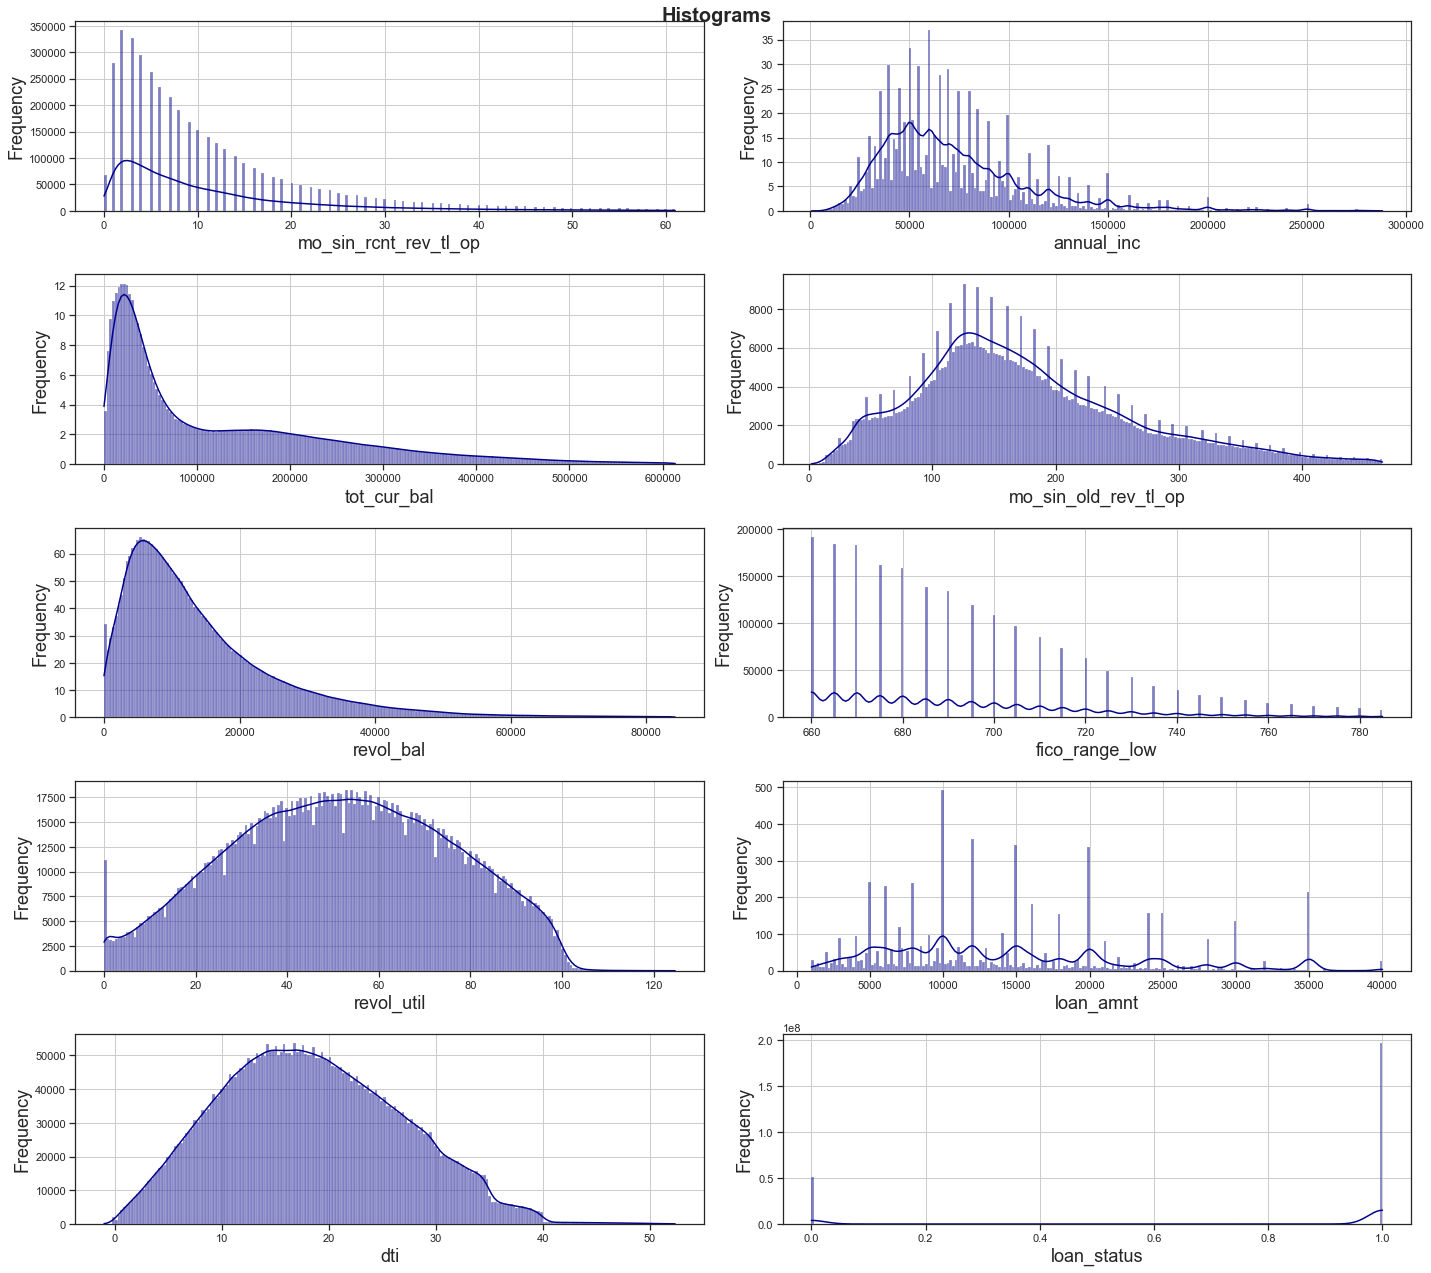

In [19]:
bins=round(np.cbrt(len(keep_df))*2) #Rice's Rule

sns.set(rc={"figure.titlesize":20,'figure.figsize':(20,10),"font.size":20,"axes.titlesize":20,"axes.labelsize":18, "axes.grid":True},style="ticks")
fig,ax = plt.subplots(5, 2, figsize=(20,18))

for i,ax in enumerate(ax.flat):
    hist=sns.histplot(data=keep_df, x=keep_df.columns[i], kde=True, bins=bins, color='darkblue', stat='frequency', ax=ax)
    fig.suptitle('Histograms',weight='bold',fontsize=20)

plt.tight_layout()
plt.show()

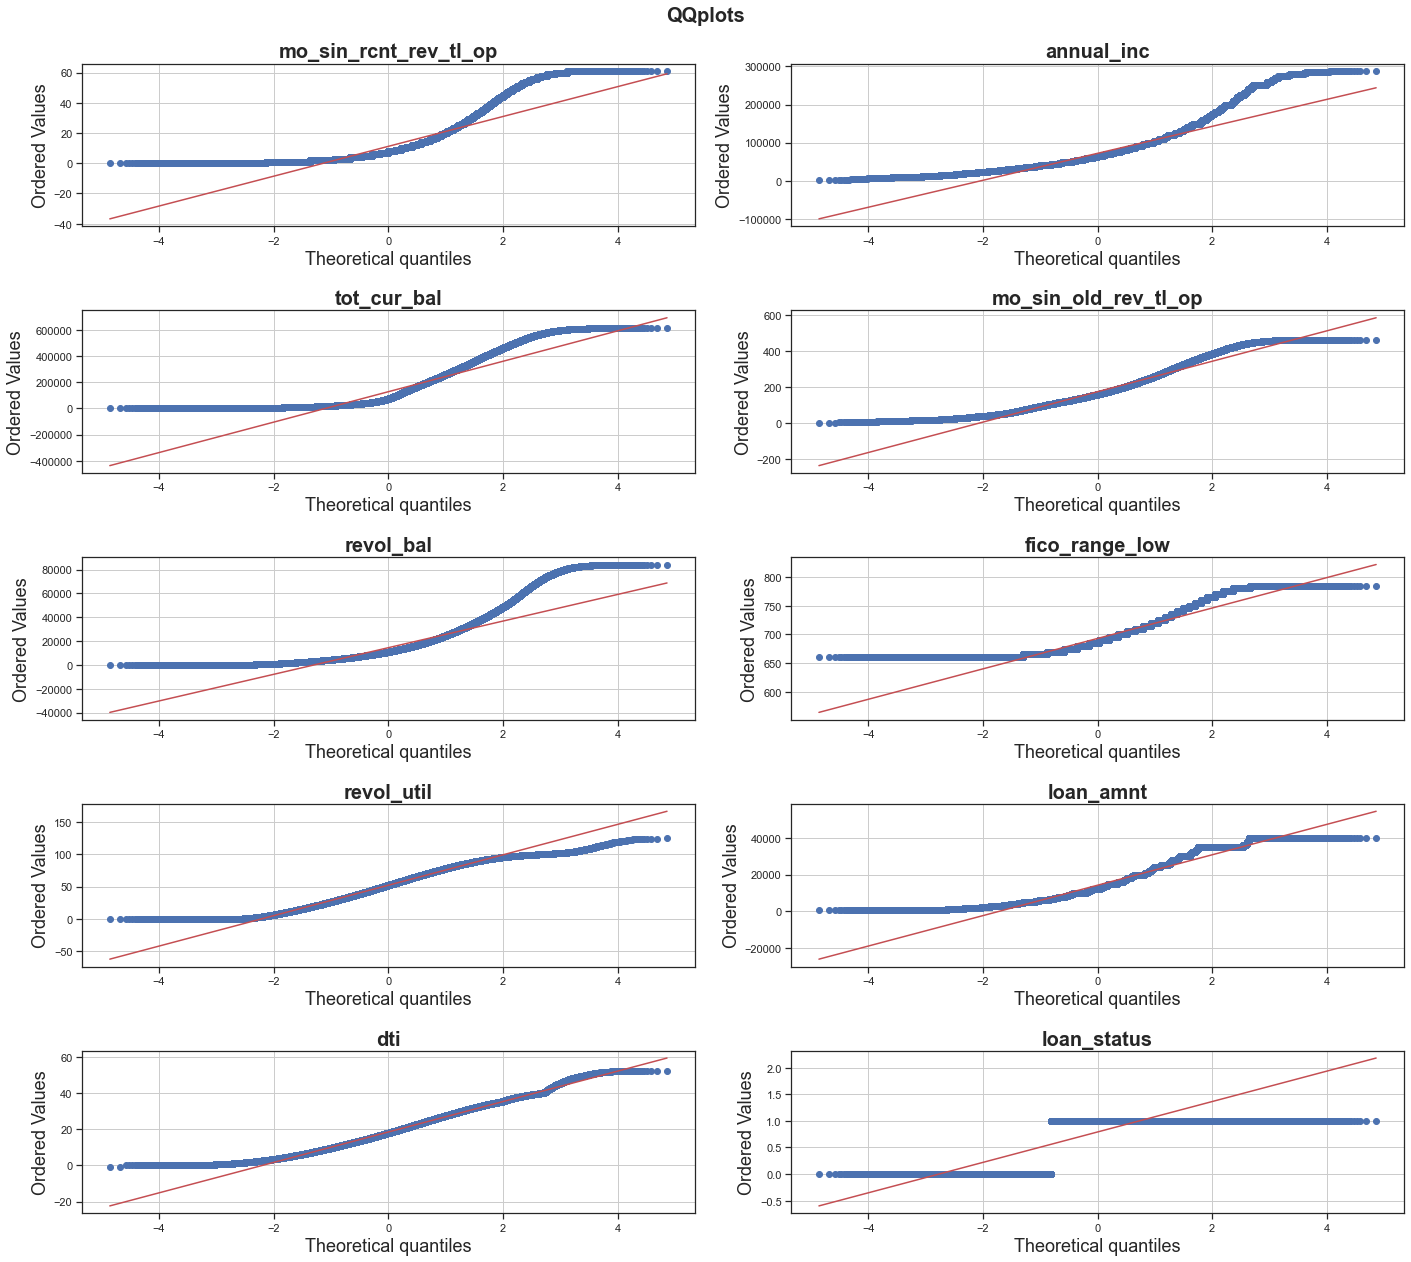

In [11]:
sns.set(rc={"figure.titlesize":20,'figure.figsize':(20,10),"font.size":20,"axes.titlesize":20,"axes.labelsize":18, "axes.grid":True},style="ticks")
fig,ax = plt.subplots(5, 2, figsize=(20,18))
for i,ax in enumerate(ax.flat):
    hist=probplot(keep_df[keep_df.columns[i]], dist="norm", plot=ax)
    ax.set_title(keep_df.columns[i],weight='bold')
    fig.suptitle('QQplots',weight='bold',fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
res=[]

for col in tqdm(keep_df.columns):
    f = Fitter(keep_df[col].values,
            distributions=get_common_distributions())
    f.fit()
    temp = f.get_best(method = 'sumsquare_error')
    temp[list(temp.keys())[0]]['Variable'] = col
    overrides = {list(temp.keys())[0]: {'distribution': list(temp.keys())[0]}}
    temp = deep_update(temp,overrides)
    temp = list(temp.values())[0]
    res.append(temp)

In [13]:
results = pd.json_normalize(res)
results = results.set_index('Variable').sort_values(by=["distribution","Variable"]) 
results

,loc,scale,distribution
Variable,,,
fico_range_low,660.000000,32.887040,expon
mo_sin_rcnt_rev_tl_op,0.000000,11.171814,expon
tot_cur_bal,0.000000,127323.235878,expon
dti,18.472485,8.446511,norm
revol_util,51.995523,23.627271,norm
annual_inc,8710.640441,51903.142405,rayleigh
loan_amnt,-578.016568,12084.147500,rayleigh
mo_sin_old_rev_tl_op,10.496074,130.919558,rayleigh
revol_bal,-4285.922992,15806.225299,rayleigh


---
### Regression Analysis
<a id='section4'></a>

In [80]:
#Keep wanted data
keep=['dti','loan_amnt','tot_cur_bal', 'revol_util','loan_status']
keep_df = df.loc[:,keep]

array = ['Charged Off', 'Fully Paid']
keep_df = keep_df.loc[keep_df['loan_status'].isin(array)]
cleaner = {"loan_status": { "Fully Paid": 1.0, "Charged Off": 0.0}}
keep_df = keep_df.replace(cleaner)
keep_df = keep_df.dropna(axis=0, how='any')

#Find and drop outliers
no_outliers_positions = keep_df[(np.abs(zscore(keep_df)) < 3).all(axis=1)].index
outliers = list(set(keep_df.index)-set(no_outliers_positions))
keep_df.drop(outliers, axis=0, inplace=True)
keep_df.reset_index(inplace=True, drop=True)

#Set lon_status as dependant variable
x=keep_df.loc[:,[col for col in keep if col !='loan_status']]
y=keep_df.loan_status

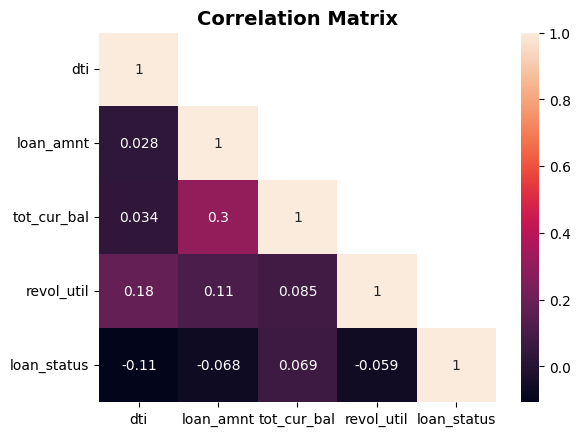

In [81]:
five = keep_df.loc[:, keep]

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(five)
mask = np.invert(np.tril(p_values<0.05)) 
sns.reset_defaults()
sns.heatmap(five.corr(), annot=True, mask=mask)
plt.title('Correlation Matrix',fontsize=14, fontweight='bold',c='black')
plt.show()

In [82]:
#Standardization
scaler = StandardScaler()
scaler.fit(x)
norm = scaler.transform(x)
norm = pd.DataFrame(norm,columns=x.columns)

#Oversample the minority 
os = SMOTE(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(norm, y, test_size=0.3, random_state=0)
os_x, os_y = os.fit_resample(x_train, y_train)

#Proportions of training data
print("~~~~~~~~~Initial data~~~~~~~~~~~~~~")
print(f"Length of training data: {len(y_train)}")
print(f"Charged Off: {round(len(y_train[y_train==0])/len(y_train),1)}%")
print(f"Fully Paid: {round(len(y_train[y_train==1])/len(y_train),1)}%")
print("~~~~~~~~~Oversampled data~~~~~~~~~")
print(f"Length of oversampled training data: {len(os_y)}")
print(f"Charged Off: {len(os_y[os_y==0])/len(os_y)}%")
print(f"Fully Paid: {len(os_y[os_y==1])/len(os_y)}%")

~~~~~~~~~Initial data~~~~~~~~~~~~~~
Length of training data: 878927
Charged Off: 0.2%
Fully Paid: 0.8%
~~~~~~~~~Oversampled data~~~~~~~~~
Length of oversampled training data: 1401362
Charged Off: 0.5%
Fully Paid: 0.5%


In [83]:
logistic = sm.Logit(os_y,os_x)
logistic_result = logistic.fit(disp=0)
print(logistic_result.summary().tables[1])

logreg = LogisticRegression()
logreg.fit(os_x, os_y)
logreg_pred = logreg.predict(x_test)

                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dti            -0.2546      0.002   -145.665      0.000      -0.258      -0.251
loan_amnt      -0.2397      0.002   -131.282      0.000      -0.243      -0.236
tot_cur_bal     0.2861      0.002    149.936      0.000       0.282       0.290
revol_util     -0.1102      0.002    -61.746      0.000      -0.114      -0.107


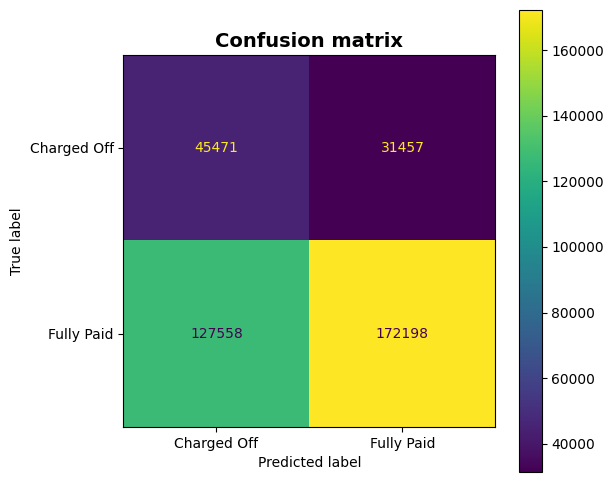

In [84]:
matrix = confusion_matrix(y_test,logreg_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ["Charged Off", "Fully Paid"], )
fig, ax = plt.subplots(figsize=(6,6))
cm_display.plot(ax=ax,values_format='d')
plt.title('Confusion matrix',fontsize=14, fontweight='bold',c='black')
plt.show()

In [85]:
pd.DataFrame(classification_report(y_test, logreg_pred,output_dict=True)).transpose().round(2)

,precision,recall,f1-score,support
0.0,0.26,0.59,0.36,76928.00
1.0,0.85,0.57,0.68,299756.00
accuracy,0.58,0.58,0.58,0.58
macro avg,0.55,0.58,0.52,376684.00
weighted avg,0.73,0.58,0.62,376684.00


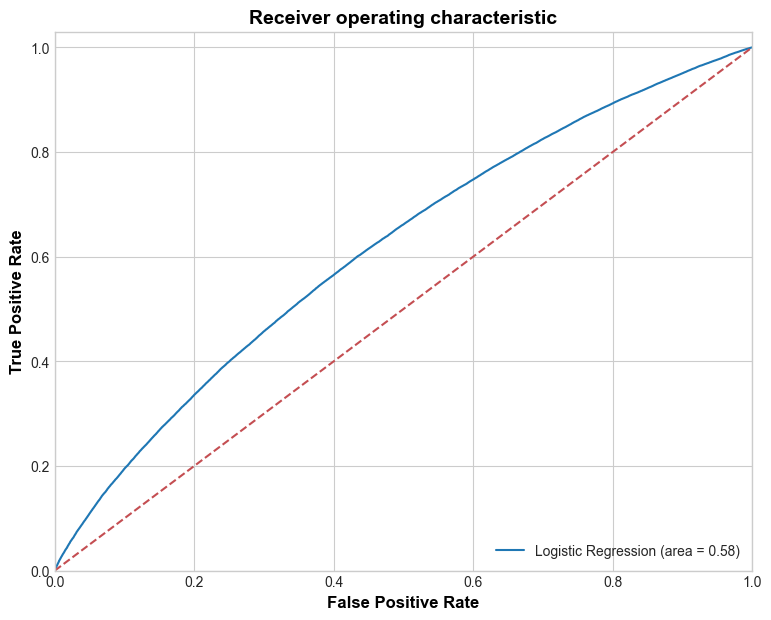

In [86]:
logit_roc_auc = roc_auc_score(y_test, logreg_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,7))
    plt.style.context('seaborn-whitegrid')
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.03])
    plt.xlabel('False Positive Rate',fontsize=12, fontweight='bold',c='black')
    plt.ylabel('True Positive Rate',fontsize=12, fontweight='bold',c='black')
    plt.title('Receiver operating characteristic',fontsize=14, fontweight='bold',c='black')
    plt.legend(loc="lower right")
    plt.show()